In [81]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn
import wandb
from wandb.keras import WandbCallback
from PIL import Image
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2



In [82]:
# Set up environment
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [83]:
ROOT_DIR = '/Users/yongjindu/Desktop/AI_proj/archive/Fish_Dataset/Fish_Dataset'
CATEGORIES = ['Hourse Mackerel',
             'Black Sea Sprat',
             'Sea Bass',
             'Red Mullet',
             'Trout',
             'Striped Red Mullet',
             'Shrimp',
             'Gilt-Head Bream',
             'Red Sea Bream']

In [84]:

# Segmentation Model Code
class SegData(Dataset):
    def __init__(self, root_dir, categories, image_paths, mask_paths):
        self.root_dir = root_dir
        self.categories = categories
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = np.array(Image.open(img_path).convert("RGB"))
        image = cv2.resize(image, (224, 224))
        
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = cv2.resize(mask, (224, 224))

        return image, mask

    def load_data(self):
        data = []
        for category in tqdm(self.categories):
            img_paths = os.path.join(self.root_dir, category, category)
            for img in os.listdir(img_paths):
                img_path = os.path.join(self.root_dir, category, category, img)
                mask_path = os.path.join(self.root_dir, category, category + ' GT', img)
                data.append([img_path, mask_path])
        
        if self.indices is not None:
            data = [data[i] for i in self.indices]
        
        return data

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(image.copy() / 255.)[None] for image in images]).float().to(device)
        masks = torch.cat([torch.from_numpy(mask / 255.).unsqueeze(0) for mask in masks]).float().to(device)
        return images, masks
    
    def get_images(self):
        return [self.__getitem__(i)[0] for i in range(len(self))]

    def get_masks(self):
        return [self.__getitem__(i)[1] for i in range(len(self))]

class UNet(nn.Module):
    def build_block(self, input_channels, output_channels, strides, kernel_size=3, padding=1):
        return nn.Sequential(*[
            nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=strides[0], padding=padding),
            nn.Conv2d(output_channels, output_channels, kernel_size=kernel_size, stride=strides[1], padding=padding),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        ])
    def __init__(self, pretrained=True, out_channels=3):
        super().__init__()
        self.block1 = self.build_block(3, 64, strides=[1, 1])
        self.block2 = self.build_block(64, 128, strides=[2, 1])
        self.block3 = self.build_block(128, 256, strides=[2, 1])
        self.bottleneck = self.build_block(256, 512, strides=[2, 1])

        self.conv_bottleneck = nn.Sequential(*[
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        ])
        self.up_conv_bottleneck = nn.Sequential(*[
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ])

        self.up_conv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = nn.Sequential(*[
            nn.Conv2d(256 + 256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        ])

        self.up_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(*[
            nn.Conv2d(128 + 128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ])

        self.up_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = nn.Sequential(*[
            nn.Conv2d(64 + 64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ])

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        bottleneck = self.bottleneck(block3)
        conv_bottleneck = self.conv_bottleneck(bottleneck)
        up_conv_bottleneck = self.up_conv_bottleneck(conv_bottleneck)  # 512x28x28

        x = self.up_conv3(up_conv_bottleneck)  # 256x56x56
        x = torch.cat([x, block3], dim=1)
        x = self.conv3(x)  # 256x56x56

        x = self.up_conv2(x)  # 128x112x112
        x = torch.cat([x, block2], dim=1)
        x = self.conv2(x)  # 128x112x112

        x = self.up_conv1(x)  # 64x224x224
        x = torch.cat([x, block1], dim=1)
        x = self.conv1(x)  # 3x224x224

        return x

def UNetLoss(preds, targets):
    ce = nn.CrossEntropyLoss()
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)

    optimizer.zero_grad()

    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)

    return loss.item(), acc.item()


In [85]:

# Classification Model Code
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 0.001
RANDOM_STATE = 77
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
METRICS = [
    "accuracy",
    "precision",
    "recall"
]

# Helper Functions
def get_dataset():
    main_directory = "/Users/yongjindu/Desktop/AI_proj/archive/Fish_Dataset/Fish_Dataset"
    image_files = []
    labels = []
    for directory in tqdm(os.listdir(main_directory)):
        next_directory = f"{main_directory}/{directory}"
        if directory in ["README.txt", "license.txt", "Segmentation_example_script.m", ".DS_Store"]:
            continue
        if os.path.isfile(next_directory):
            continue
        for images_directory in os.listdir(next_directory):
            if "GT" not in images_directory:
                final_directory = f"{next_directory}/{images_directory}"
                if os.path.isfile(final_directory):
                    continue
                for item in os.listdir(final_directory):
                    item_path = os.path.join(final_directory, item)
                    if os.path.isfile(item_path) and item.lower().endswith((".png", ".jpg", ".jpeg", ".gif")):
                        image_files.append(item)
                        labels.append(images_directory)
    return image_files, labels

def plot_training_images(images, labels):
    plot_images = []
    plot_labels = []
    for i, j in zip(images, labels):
        if j in plot_labels:
            continue
        else:
            plot_images.append(i)
            plot_labels.append(j)
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, figsize=(12, 12))
    for i in range(3):
        for j in range(3):
            axes[i][j].imshow(plot_images[i * 3 + j])
            axes[i][j].set_xlabel(plot_labels[i * 3 + j])
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
    plt.tight_layout()
    plt.show()

def get_tf_dataset(images, labels):
    return tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE).prefetch(1)

def split_dataset(images, labels, test_size=0.2, valid_size=0.2):
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=RANDOM_STATE)
    train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=valid_size, random_state=RANDOM_STATE)
    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)

def plot_cm(test_labels, prediction_labels, encoder):
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(test_labels, prediction_labels)
    df_cm = pd.DataFrame(cm, index=[i for i in encoder.categories_[0]],
                         columns=[i for i in encoder.categories_[0]])
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
    plt.show()

def plot_history(history):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    # Training
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax=axes[0][0])
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax=axes[0][1])
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["precision"], ax=axes[1][0])
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["recall"], ax=axes[1][1])
    # Validation
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax=axes[0][0])
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax=axes[0][1])
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_precision"], ax=axes[1][0])
    sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_recall"], ax=axes[1][1])

    axes[0][0].set_title("Loss Comparison", fontdict={'fontsize': 20})
    axes[0][0].set_xlabel("Epoch")
    axes[0][0].set_ylabel("Loss")

    axes[0][1].set_title("Accuracy Comparison", fontdict={'fontsize': 20})
    axes[0][1].set_xlabel("Epoch")
    axes[0][1].set_ylabel("Accuracy")

    axes[1][0].set_title("Precision Comparison", fontdict={'fontsize': 20})
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Precision")

    axes[1][1].set_title("Recall Comparison", fontdict={'fontsize': 20})
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("Recall")
    plt.tight_layout()
    plt.show()

def get_resnet(categories):
    conv_block = tf.keras.applications.ResNet50(include_top=False, weights=None)
    conv_block.load_weights("./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", by_name=True)
    x = conv_block.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    output = tf.keras.layers.Dense(categories, activation='softmax')(x)
    model = tf.keras.Model(inputs=conv_block.input, outputs=output)
    return model, "ResNet50"


In [86]:

# Dataset Preprocessing
image_files, labels = get_dataset()
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=RANDOM_STATE)
train_files, valid_files, train_labels, valid_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=RANDOM_STATE)

train_labels_str = train_labels
valid_labels_str = valid_labels
test_labels_str = test_labels

train_image_paths = [os.path.join(ROOT_DIR, label, label, img) for img, label in zip(train_files, train_labels_str)]
train_mask_paths = [os.path.join(ROOT_DIR, label, label + ' GT', img) for img, label in zip(train_files, train_labels_str)]

valid_image_paths = [os.path.join(ROOT_DIR, label, label, img) for img, label in zip(valid_files, valid_labels_str)]
valid_mask_paths = [os.path.join(ROOT_DIR, label, label + ' GT', img) for img, label in zip(valid_files, valid_labels_str)]

test_image_paths = [os.path.join(ROOT_DIR, label, label, img) for img, label in zip(test_files, test_labels_str)]
test_mask_paths = [os.path.join(ROOT_DIR, label, label + ' GT', img) for img, label in zip(test_files, test_labels_str)]

100%|██████████| 13/13 [00:00<00:00, 119.38it/s]


In [87]:
# Load the segmentation model
seg_model = UNet().to(device)
criterion = UNetLoss
optimizer = optim.Adam(seg_model.parameters(), lr=1e-3)
n_epochs = 1


In [88]:
# Preprocessing transforms for segmentation
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, .456, 406],
                         [.229, 224, 225])
])


In [89]:
# Function to apply segmentation mask to an image

train_seg_data = SegData(root_dir=ROOT_DIR, categories=CATEGORIES, image_paths=train_image_paths, mask_paths=train_mask_paths)
valid_seg_data = SegData(root_dir=ROOT_DIR, categories=CATEGORIES, image_paths=valid_image_paths, mask_paths=valid_mask_paths)
test_seg_data = SegData(root_dir=ROOT_DIR, categories=CATEGORIES, image_paths=test_image_paths, mask_paths=test_mask_paths)

def apply_segmentation_mask(image, mask):
    segmented_image = cv2.bitwise_and(image, image, mask=(mask > 0.5).astype(np.uint8))
    return segmented_image



In [90]:
train_images_segmented = []
train_labels_segmented = []
for i, (image, mask) in enumerate(train_seg_data):
    segmented_image = apply_segmentation_mask(image, mask)
    train_images_segmented.append(segmented_image)
    category = os.path.basename(os.path.dirname(train_seg_data.image_paths[i]))
    train_labels_segmented.append(train_seg_data.categories.index(category))

valid_images_segmented = []
valid_labels_segmented = []
for i, (image, mask) in enumerate(valid_seg_data):
    segmented_image = apply_segmentation_mask(image, mask)
    valid_images_segmented.append(segmented_image)
    category = os.path.basename(os.path.dirname(valid_seg_data.image_paths[i]))
    valid_labels_segmented.append(valid_seg_data.categories.index(category))

test_images_segmented = []
test_labels_segmented = []
for i, (image, mask) in enumerate(test_seg_data):
    segmented_image = apply_segmentation_mask(image, mask)
    test_images_segmented.append(segmented_image)
    category = os.path.basename(os.path.dirname(test_seg_data.image_paths[i]))
    test_labels_segmented.append(test_seg_data.categories.index(category))

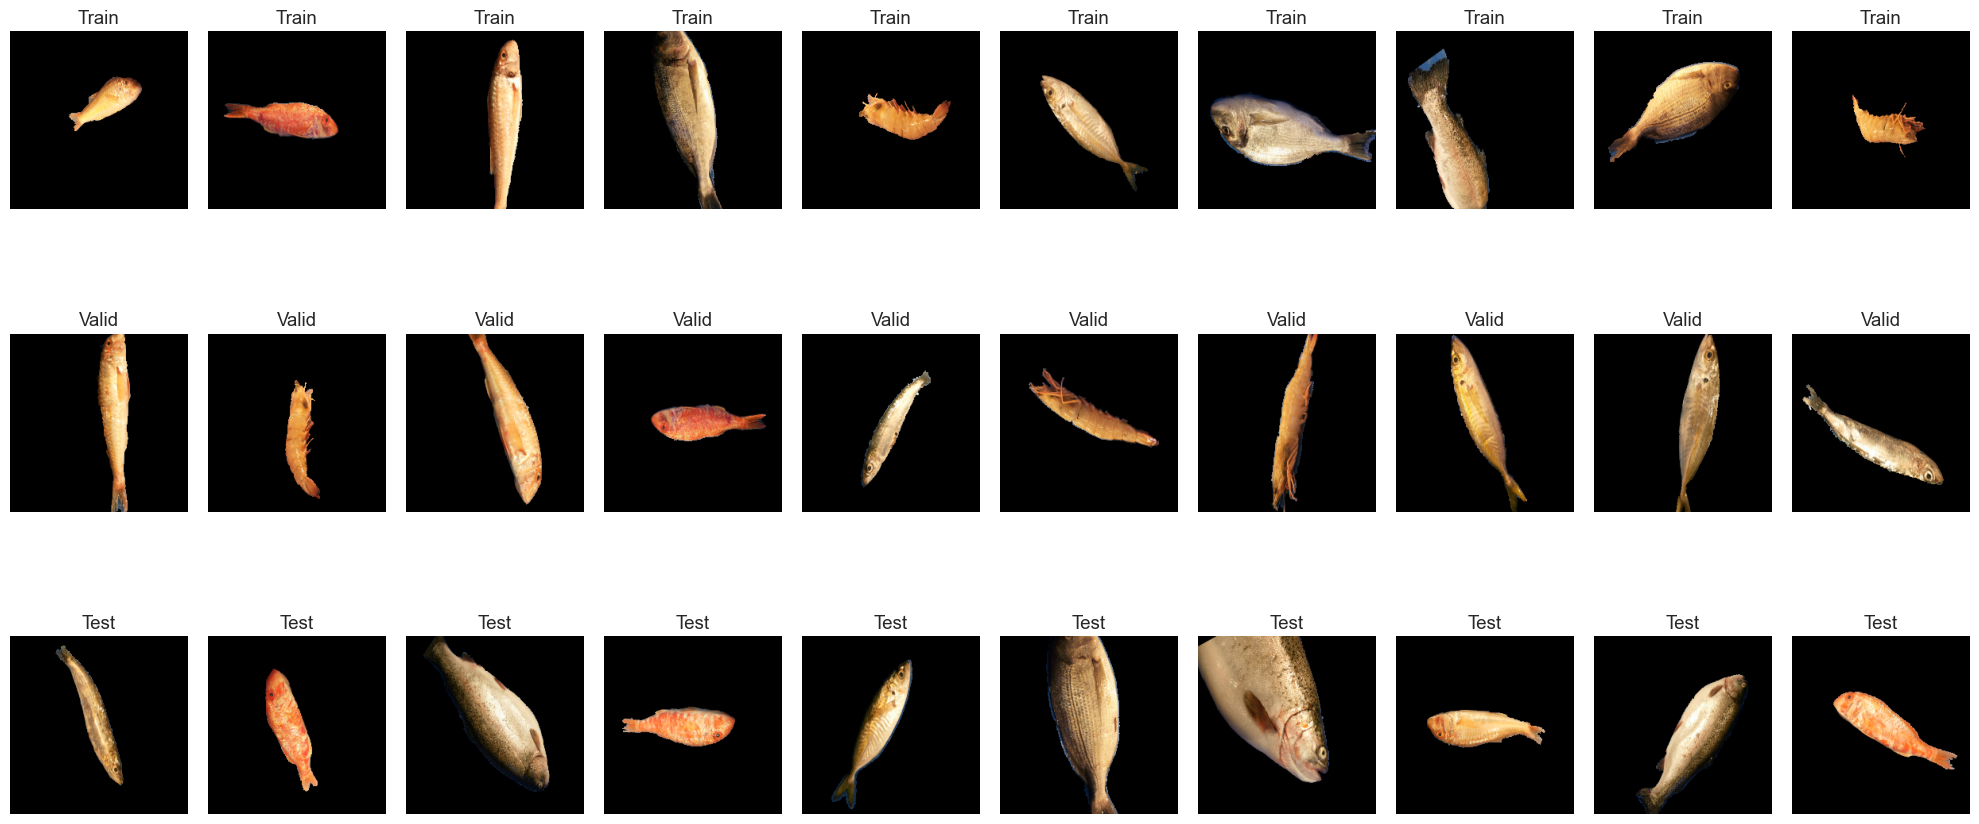

In [91]:
def visualize_segmented_images(train_images_segmented, valid_images_segmented, test_images_segmented, num_samples=10):
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 10))

    for i in range(num_samples):
        axes[0, i].imshow(train_images_segmented[i])
        axes[0, i].set_title("Train")
        axes[0, i].axis("off")

        axes[1, i].imshow(valid_images_segmented[i])
        axes[1, i].set_title("Valid")
        axes[1, i].axis("off")

        axes[2, i].imshow(test_images_segmented[i])
        axes[2, i].set_title("Test")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize the segmented images
visualize_segmented_images(train_images_segmented, valid_images_segmented, test_images_segmented)

In [92]:
# Create TensorFlow datasets with segmented images
train_images_segmented = np.array(train_images_segmented)
train_labels_segmented = np.array(train_labels_segmented)

valid_images_segmented = np.array(valid_images_segmented)
valid_labels_segmented = np.array(valid_labels_segmented)

test_images_segmented = np.array(test_images_segmented)
test_labels_segmented = np.array(test_labels_segmented)


encoder = OneHotEncoder(categories=[CATEGORIES])
train_labels_segmented =encoder.fit_transform(np.array(train_labels_str).reshape(-1, 1)).toarray()
valid_labels_segmented =encoder.transform(np.array(valid_labels_str).reshape(-1, 1)).toarray()
test_labels_segmented = encoder.transform(np.array(test_labels_str).reshape(-1, 1)).toarray()
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_segmented, train_labels_segmented)).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images_segmented, valid_labels_segmented)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_segmented,test_labels_segmented)).batch(BATCH_SIZE)



In [93]:
# Load the classification model
class_model, model_name = get_resnet(len(encoder.categories_[0]))
class_model.load_weights('./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

config_defaults = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "model_name": model_name,
  "loss": LOSS,
  "random_state": RANDOM_STATE,
  "optimizer": OPTIMIZER,
  "metrics": METRICS
}
class_model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = class_model.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=EPOCHS,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)])

Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 955s 3s/step - accuracy: 0.6208 - loss: 1.1575 - precision_3: 0.7299 - recall_3: 0.5127 - val_accuracy: 0.1896 - val_loss: 18.7766 - val_precision_3: 0.1919 - val_recall_3: 0.1854
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 998s 3s/step - accuracy: 0.9282 - loss: 0.2105 - precision_3: 0.9356 - recall_3: 0.9213 - val_accuracy: 0.1097 - val_loss: 24.4681 - val_precision_3: 0.1099 - val_recall_3: 0.1090
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 959s 3s/step - accuracy: 0.9548 - loss: 0.1280 - precision_3: 0.9585 - recall_3: 0.9510 - val_accuracy: 0.8125 - val_loss: 0.6923 - val_precision_3: 0.8244 - val_recall_3: 0.8083
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1034s 3s/step - accuracy: 0.9673 - loss: 0.1019 - precision_3: 0.9702 - recall_3: 0.9657 - val_accuracy: 0.5479 - val_loss: 2.7634 - val_precision_3: 0.5492 - val_recall_3: 0.5424
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1133s 3s/step - accuracy: 0.9718 - loss: 0.0784 - precision_3: 0.9746 - recall_3: 0.97

In [94]:

result_inter = class_model.predict(test_dataset)


113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 613ms/step


In [95]:
prediction_index = np.argmax(result_inter, axis=-1)
result = np.zeros(shape=test_labels_segmented.shape, dtype=test_labels_segmented.dtype)
for i in range(result.shape[0]):
    result[i][prediction_index[i]] = 1.0

In [96]:
test_labels_decoded = [encoder.categories_[0][label] for label in test_labels_segmented.argmax(axis=1)]
prediction_labels_decoded = [encoder.categories_[0][label] for label in result.argmax(axis=1)]

                    precision    recall  f1-score   support

   Black Sea Sprat       0.76      0.93      0.83       203
   Gilt-Head Bream       1.00      0.58      0.73       202
   Hourse Mackerel       0.88      0.93      0.91       199
        Red Mullet       0.71      0.96      0.82       212
     Red Sea Bream       0.79      0.94      0.85       203
          Sea Bass       0.87      0.99      0.92       217
            Shrimp       0.85      0.99      0.92       187
Striped Red Mullet       1.00      0.04      0.07       180
             Trout       0.89      1.00      0.94       197

          accuracy                           0.83      1800
         macro avg       0.86      0.82      0.78      1800
      weighted avg       0.86      0.83      0.79      1800


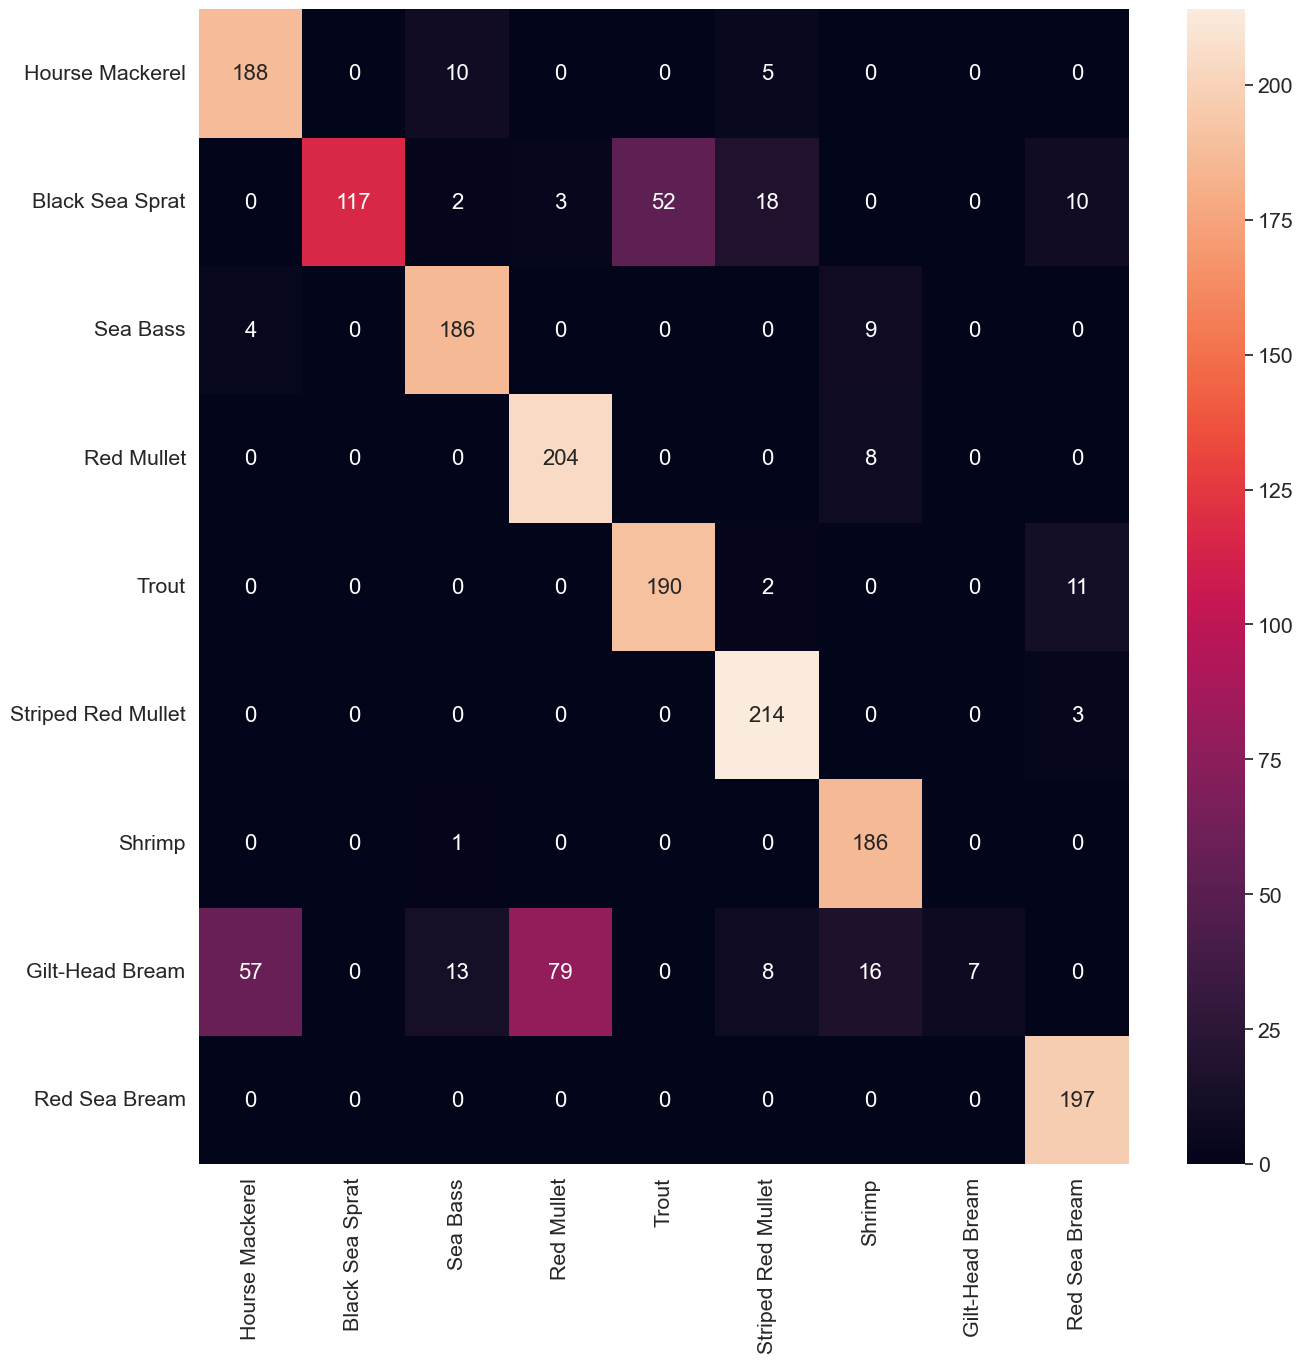

In [97]:
print(classification_report(test_labels_decoded, prediction_labels_decoded))
plot_cm(test_labels_decoded, prediction_labels_decoded, encoder)

In [98]:
print(encoder.categories_)

[array(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
       'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
       'Red Sea Bream'], dtype=object)]
